In [1]:
import numpy as np
import pickle as pkl
from Extractor import Extractor
from scipy.sparse import coo_matrix,csr_matrix
#import tensorflow as tf
import torch
from utils import *
import networkx as nx
from matplotlib import pyplot as plt
from model import *
from train import *

from explain import *
import time
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
dataset_name = 'syn3'

ModuleNotFoundError: No module named 'numpy'

In [2]:
with open('./dataset/' + dataset_name + '.pkl', 'rb') as fin:
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, edge_label_matrix  = pkl.load(fin)
hops = 3
allnodes = [i for i in range(511,871,6)]
all_label = np.logical_or(y_train,np.logical_or(y_val,y_test))
csr_adj = csr_matrix(adj)
extractor = Extractor(csr_adj,features,edge_label_matrix,all_label,hops)
sub_adj,sub_feature, sub_label,sub_edge_label_matrix = extractor.subgraph(allnodes[0])
single_label = np.argmax(all_label,axis=-1)
len([i for i in range(single_label.shape[0]) if single_label[i] ==1])

explainer


360

In [3]:
class BA_Shape_Dataset(Dataset):
    def __init__(self, root, name, hops=3,transform = None, pre_transform = None, subgraph = False, remap=False):
        super(BA_Shape_Dataset, self).__init__(root, transform, pre_transform)
        self.root = root
        self.subgraph = subgraph
        self.remap = remap
        self.name = name
        self.setting = 1
        with open(os.path.join(self.root, name + '.pkl'), 'rb') as fin:
            self.adj, self.features, self.y_train, self.y_val, self.y_test, self.train_mask, self.val_mask, self.test_mask, self.edge_label_matrix  = pkl.load(fin)
        self.hops = hops

        self.all_label = np.logical_or(self.y_train,np.logical_or(self.y_val,self.y_test))
        self.single_label = np.argmax(self.all_label,axis=-1)
        #self.allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] != 0] #[i for i in range(400,700,5)]
        self.csr_adj = csr_matrix(self.adj)
        self.extractor = Extractor(self.csr_adj,self.features,self.edge_label_matrix,self.all_label,self.hops)            
    @property
    def num_features(self):
        return 10
    @property
    def num_classes(self):
        return self.all_label.shape[1]

    @property 
    def allnodes(self):
        if self.setting==1:
            if self.name=='syn3':
                allnodes = [i for i in range(511,871,6)]
            elif self.name=='syn4':
                allnodes = [i for i in range(511,800,1)]
            else:
                allnodes = [i for i in range(400,700,5)] # setting from their original paper
        elif self.setting==2:
            allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] ==1]
        elif self.setting==3:
            if self.name == 'syn2':
                allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] != 0 and self.single_label[i] != 4]
            else:
                allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] != 0]
        return allnodes

        
    def get_subgraph(self, idx):
        #if self.subgraph:
        idx = self.allnodes[idx] if self.remap else idx
        sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.extractor.subgraph(idx)
        return sub_adj,sub_feature, sub_label,sub_edge_label_matrix
        #else:
        #    return None
    def len(self):
        if self.subgraph:
            if not self.remap:
                return len(self.single_label)
            return len(self.allnodes)
        else:
            return 1
    
    def get(self, idx):
        if self.subgraph:
            if self.remap:
                idx = self.allnodes[idx]
            sub_adj,sub_feature, sub_label,sub_edge_label_matrix = self.extractor.subgraph(idx)
            edge_index = torch.tensor(preprocess_adj(sub_adj)[0].T, dtype = torch.long)
            x = torch.tensor(sub_feature).float()
            y = torch.argmax(torch.tensor(sub_label, dtype = torch.int32), dim=-1)
            data = Data(edge_index = edge_index, x = x, y = y)
        else:

            edge_index = torch.tensor(preprocess_adj(self.adj)[0].T, dtype = torch.long)
            x = torch.tensor(self.features).float()
            y = torch.argmax(torch.tensor(np.logical_or(self.y_train,np.logical_or(self.y_val,self.y_test)), dtype = torch.int32), dim=-1)
            data = Data(edge_index = edge_index, x = x, y = y)
        return data

In [4]:
dataset = BA_Shape_Dataset(root = './dataset', name = 'syn3', hops=3)

explainer


In [6]:
gcn_model = GCN_Node(dataset, 3, 20)
#gcn_model = torch.load('./checkpoint/gcn_mix')

In [7]:
dataset.setting = 3
dataset.subgraph = False
dataset.remap = True
#train(gcn_model, dataset, max_epoch=1000, lr=0.005, train_batch_size = 1024, temp_name = 'community_temp')
node_pred_task_train(gcn_model, dataset, max_epoch=1000, lr=0.005, temp_name='cycles_temp', train_rate = 0.80)

prepare dataloader
done
Epoch:  0 Avg loss:  0.70655555 ; acc:  0.4051724 ; epoch time:  0.49917006492614746
eval test...
test acc:  0.4457143
test loss:  0.70181465
saving...


Epoch:  1 Avg loss:  0.69594425 ; acc:  0.4051724 ; epoch time:  0.26319146156311035
eval test...
test acc:  0.4457143
test loss:  0.6946191
saving...


Epoch:  2 Avg loss:  0.6885851 ; acc:  0.5948276 ; epoch time:  0.23415851593017578
eval test...
test acc:  0.5542857
test loss:  0.69070715
saving...


Epoch:  3 Avg loss:  0.6827685 ; acc:  0.5948276 ; epoch time:  0.2637474536895752
eval test...
test acc:  0.5542857
test loss:  0.6881398
saving...


Epoch:  4 Avg loss:  0.67898864 ; acc:  0.5948276 ; epoch time:  0.2576749324798584
eval test...
test acc:  0.5542857
test loss:  0.68713826
saving...


Epoch:  5 Avg loss:  0.6768262 ; acc:  0.5948276 ; epoch time:  0.24293279647827148
eval test...
test acc:  0.5542857
test loss:  0.68782884


Epoch:  6 Avg loss:  0.6762127 ; acc:  0.5948276 ; epoch time:  0.241

In [11]:
dataset.subgraph = False
dataset.remap = True
train(gcn_model, dataset, max_epoch=100, lr=0.01)

prepare dataloader
done
Epoch:  0 Avg loss:  0.49192926 ; acc:  0.7749713 ; epoch time:  0.3157958984375
Epoch:  1 Avg loss:  0.8362259 ; acc:  0.44776118 ; epoch time:  0.308856725692749
Epoch:  2 Avg loss:  0.5078893 ; acc:  0.7944891 ; epoch time:  0.33263707160949707
Epoch:  3 Avg loss:  0.7469407 ; acc:  0.5154994 ; epoch time:  0.31592273712158203
Epoch:  4 Avg loss:  0.64065737 ; acc:  0.5970149 ; epoch time:  0.33408093452453613
Epoch:  5 Avg loss:  0.52725434 ; acc:  0.7956372 ; epoch time:  0.3188478946685791
Epoch:  6 Avg loss:  0.555634 ; acc:  0.7600459 ; epoch time:  0.30664920806884766
Epoch:  7 Avg loss:  0.61718714 ; acc:  0.46613088 ; epoch time:  0.32619738578796387
Epoch:  8 Avg loss:  0.6199382 ; acc:  0.5430539 ; epoch time:  0.32158732414245605
Epoch:  9 Avg loss:  0.55608094 ; acc:  0.5901263 ; epoch time:  0.3105478286743164
Epoch:  10 Avg loss:  0.49552268 ; acc:  0.7577497 ; epoch time:  0.30218505859375
Epoch:  11 Avg loss:  0.53046834 ; acc:  0.7921929 ; ep

In [8]:
dataset.subgraph = False
dataset.remap = False
eval(gcn_model, dataset)

Epoch:  0 Avg loss:  0.3314973 ; acc:  0.8438576 ; epoch time:  0.02238321304321289


array(0.8438576, dtype=float32)

In [7]:
torch.save(gcn_model, './checkpoint/gcn_cycles')

In [18]:
load_model = torch.load('./checkpoint/gcn_model').to('cuda')

In [32]:
dataset.subgraph = True
data = get_data(dataset, 33).to('cuda')

In [12]:
correct = 0
dataset.subgraph = True
dataset.remap = True
dataset.setting = 1
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
load_model = gcn_model
load_model.eval()
in_correct = []
for idx in range(dataset.len()):
    print('index: ', idx)
    data = get_data(dataset, idx).to('cuda')
    pred = load_model.forward(data)
    #print(preds)
    label = data.y.to('cuda')

    _, indices = torch.max(pred, 1)
    #print(pred)
    print(label)
    print(torch.sum(label))
    print(indices)
    #print(torch.argmax(load_model(data)[0]))
    if (indices[0] == 1.0):
        correct += 1
    else:
        in_correct.append(idx)
print(correct)
print(in_correct)

index:  0
tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
tensor(6, device='cuda:0')
tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
index:  1
tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
tensor(6, device='cuda:0')
tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
index:  2
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
tensor(7, device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
index:  3
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
tensor(6, device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
index:  4
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
tensor(6, device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
index:  5
tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], devic

In [41]:
acc_list = []
auc_list = []
node_num_list = []
dataset.setting = 1
dataset.subgraph = True
dataset.remap = False
load_model = gcn_model
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
load_model.eval()

all_node_label = []
all_node_color = []
for idx in dataset.allnodes:
    #if idx in in_correct:
    #    continue
    print('\nindex========================================= ', idx)
    if indices[idx] == 0:
        continue
    sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.get_subgraph(idx)
    #truth_node = np.where(sub_label[:,1] == True)[0]
    truth_node = get_node_set(sub_edge_label_matrix)
    #if len(truth_node) > 6:
    #    continue
    class_index = np.argmax(sub_label[0],axis=-1)
    node_sort, node_color = print_explain(dataset, load_model, idx, class_idx = np.argmax(sub_label[0],axis=-1), visible = False)

    node_label = np.array([0] * sub_label.shape[0])
    node_label[list(truth_node)] = 1
    pred  = np.array([0] * sub_label.shape[0])
    pred[node_sort[:6]] = 1
    
    edge_label = []
    edge_pred = []
    for r,c in list(zip(sub_adj.row,sub_adj.col)):
        sub_edge_label = sub_edge_label_matrix.todense()
        edge_label.append(sub_edge_label[r,c] or sub_edge_label[c,r])
        edge_pred.append((node_color[r] + node_color[c])/2)
    #print(edge_label)
    try:
        auc = roc_auc_score(node_label, node_color)
    except:
        print('foo')
        auc = 1.0
    #auc = 1.0 if len(label) == 6 else roc_auc_score(edge_label, edge_pred)
    #auc = roc_auc_score(label, node_color)
    node_num_list.append(len(truth_node))

    #print(edge_label)
    #print(edge_pred)
    #print(truth_node)
    #print(node_sort)
    acc = len([node for node in node_sort[:len(truth_node)] if node in truth_node])/len(truth_node)
    acc_list.append(acc)
    #auc_list.append(auc)
    all_node_label.extend(node_label)
    all_node_color.extend(node_color)
    print('acc: ', acc)

    
    

    edge_dense = sub_edge_label_matrix.todense()
    edge_list = preprocess_adj(sub_edge_label_matrix)[0]
    edge_label = []
    for r,c in list(zip(sub_adj.row,sub_adj.col)):
        edge_label.append(edge_dense[r,c] or edge_dense[c,r])



    edge_score = Edge_explain(load_model, dataset, idx = idx, edge_list = edge_list)
    edge_colors = []
    for i in range(len(edge_score[0]['rel'])):
        edge_colors.append( edge_score[class_index]['rel'][i] - edge_score[0]['rel'][i] )
    print('edge sort: ', np.argsort(edge_colors)[::-1])
    #print(edge_list[np.argsort(edge_colors)[::-1]])
    try:
        auc = roc_auc_score(edge_label,edge_colors)
    except:
        auc = 1.0
    print('auc: ', auc)
    auc_list.append(auc)


    print('mean acc: ', np.mean(acc_list))
    print('auc mean: ', np.mean(auc_list))
 


index=========================================  511
target node:  0
epoch time:  0.33122706413269043
acc:  0.8333333333333334
have edge_list
edge sort:  [ 1 23 25  2  0  5 22  6 14 24 27 13  8 26  9  4 10  7  3 15 12 21 20 11
 19 18 17 16]
auc:  0.9166666666666666
mean acc:  0.8333333333333334
auc mean:  0.9166666666666666

index=========================================  517
target node:  0
epoch time:  0.3672206401824951
acc:  0.8333333333333334
have edge_list
edge sort:  [31  3 27 30 18  5 11 28  8 19  7  6 12 25  9 24 16 14 26  4 15 29 21 10
 22 13 17  0 20  2 23  1]
auc:  0.16666666666666666
mean acc:  0.8333333333333334
auc mean:  0.5416666666666666

index=========================================  523
target node:  0
epoch time:  0.3673539161682129
acc:  0.8333333333333334
have edge_list
edge sort:  [33  7  8 17  9 13  4 11 12  5 10 15 16 26 28  6 21 25 23 22 27  3 30 14
 20 19 24 32 29  0  1 18  2 31]
auc:  0.12121212121212122
mean acc:  0.8333333333333334
auc mean:  0.401515151

In [57]:
edge_label

[0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [59]:
edge_list

[[0, 1],
 [0, 10],
 [0, 11],
 [1, 5],
 [1, 3],
 [1, 0],
 [2, 10],
 [2, 3],
 [2, 12],
 [3, 1],
 [3, 2],
 [3, 8],
 [3, 9],
 [4, 12],
 [4, 11],
 [5, 1],
 [5, 6],
 [5, 7],
 [6, 5],
 [7, 5],
 [8, 3],
 [9, 3],
 [10, 2],
 [10, 0],
 [11, 4],
 [11, 0],
 [12, 2],
 [12, 4]]

In [60]:
preprocess_adj(sub_edge_label_matrix)

(array([[ 0,  1],
        [ 0, 10],
        [ 0, 11],
        [ 1,  5],
        [ 1,  3],
        [ 1,  0],
        [ 2, 10],
        [ 2,  3],
        [ 2, 12],
        [ 3,  1],
        [ 3,  2],
        [ 3,  8],
        [ 3,  9],
        [ 4, 12],
        [ 4, 11],
        [ 5,  1],
        [ 5,  6],
        [ 5,  7],
        [ 6,  5],
        [ 7,  5],
        [ 8,  3],
        [ 9,  3],
        [10,  2],
        [10,  0],
        [11,  4],
        [11,  0],
        [12,  2],
        [12,  4]], dtype=int32),
 array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.], dtype=float32),
 (13, 13))

In [25]:
data = get_data(dataset, idx = 2)
data.x.shape

torch.Size([25, 10])

In [32]:
from utils import *
import torch
from CD_layers import *
import time
from torch_geometric.utils import to_networkx
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

def find_edge(model, dataset, idx, class_idx = None, node_sort = None, topk = None, start_num = 2):
    if node_sort is None:
        node_sort, node_color = print_explain(dataset, model, idx, class_idx = class_idx, visible = False)
    if class_idx is None:
        class_idx = int(dataset[idx].y[0])
    data = get_data(dataset, idx)
    data = data.to(device)
    start_num = start_num
    
    rest = list(node_sort.copy())
    select = set()
    neighbor_nodes = set()
    select_node_progress = []
    edge_index = np.array(dataset[idx].edge_index)

    while len(select) < topk and len(rest) != 0:
        if len(neighbor_nodes) == 0:
            for _ in range(start_num):
                if len(rest) == 0:
                    pass
                select_node = rest[0]
                select.add(select_node)
                rest.remove(select_node)
                # add new neighbor edge
                temp_neighbor_idx = (np.where(edge_index[0] == select_node))[0]
                #print(temp_neighbor_idx)
                for n_idx in temp_neighbor_idx:
                    n = int(edge_index[1][n_idx])
                    if n not in select:
                        neighbor_nodes.add(n)
                try:
                    neighbor_nodes.remove(select_node)
                except:
                    pass
                #print('no neighbor')
                #print('select: ', select)
                #print('neighbor_nodes', neighbor_nodes)
            select_node_progress.append(select.copy())
            
        else:
            # prepare list for score
            check_list = []
            for node in neighbor_nodes:
                group = select.copy()
                group.add((int)(node))
                check_list.append(group)
            #print(check_list)
            class_score = get_score(model, data, mask_list = check_list.copy())
            group_scores = class_score[class_idx]['rel']
            group_rank = np.argsort(group_scores)[::-1]
            #print(group_rank)
            select = check_list[group_rank[0]]
            #print(check_list)
            intersect = select.intersection(neighbor_nodes)
            #print(intersect)
            neighbor_nodes = neighbor_nodes - select
            #print(rest)
            for node in intersect:
                rest.remove(node)
                # add new neighbor edge
                temp_neighbor_idx = (np.where(edge_index[0] == node))[0]
                #print('temp_neighbor_idx', temp_neighbor_idx)
                for n_idx in temp_neighbor_idx:        
                    n = int(edge_index[1][n_idx])
                    if n not in select:
                        neighbor_nodes.add(n)
            select_node_progress.append(select.copy())
        size = max(edge_index[0]) + 1
        adj = np.zeros((size, size))
        edge_pred = []
        for i in range(edge_index.shape[1]):
            r = edge_index[0][i]
            c = edge_index[1][i]
            if r in select and c in select:
                adj[r][c] = 1
                adj[c][r] = 1
            
            if r < c:
                if r in select and c in select:
                    edge_pred.append(1)
                else:
                    edge_pred.append(0)

        adj = preprocess_adj(adj)
    return select,select_node_progress,adj,edge_pred

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def CD_explain(model, dataset, idx = 0, mask_node_list = None, node_range = None):
    """
    idx: idx of graph to explain
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    data = get_data(dataset, idx)
    data = data.to(device)


    mask_list = []
    # generate mask
    node_range = data.x.shape[0] if node_range is None else node_range
    '''
    for i in range(node_range):
        # generate data idx mask to check
        mask_index = [0] * data.x.shape[0]
        mask_index[i] = 1
        if mask_node_list is not None and i in mask_node_list:
            for n in mask_node_list:
                print(i)
                print(mask_node_list)
                mask_index[n] = 1
        mask_list.append(mask_index)
    '''

    for i in range(node_range):
        if mask_node_list is not None and i in mask_node_list:
            mask_list.append(mask_node_list)
        else:
            mask_list.append([i])
    # forward to explain according to mask list
    class_score = get_score(model, data, mask_list)
    return class_score
def get_score(model, data, mask_list):
    mask_index_list = []
    for i in range(len(mask_list)):
        mask_index = [0] * data.x.shape[0]

        for m in mask_list[i]:

            mask_index[m] = 1
        #mask_list[i] = mask_index
        mask_index_list.append(mask_index)
    
    preds_list = []
    for mask_index in mask_index_list:
        model.zero_grad()
        preds = model.forward(data, CD_explain=True, mask_index = mask_index)
        #print(preds)
        #print(data.y)
        preds['rel'] = preds['rel'].T
        preds['irrel'] = preds['irrel'].T
        #print(preds['irrel'].shape[0])
        #print(dataset.num_classes)
        preds = CD_softmax(preds, index = torch.tensor([0] * preds['irrel'].shape[0]).to(device))
        preds_list.append(preds)
        # need to softmax??

    # rel cd score for each class
    class_score = {}
    for class_idx in range(preds['irrel'].shape[0]):
        class_score[class_idx] = {}
        class_score[class_idx]['rel'] = []
        class_score[class_idx]['irrel'] = []
        for preds in preds_list:
            class_score[class_idx]['rel'].append((float)((preds['rel'][class_idx][0].cpu().detach())))
            class_score[class_idx]['irrel'].append((float)((preds['irrel'][class_idx][0].cpu().detach())))
            #class_score[class_idx]['rel'].append((float)((preds['rel'][0][class_idx].cpu().detach())))
            #class_score[class_idx]['irrel'].append((float)((preds['irrel'][0][class_idx].cpu().detach())))

    return class_score

def print_explain(dataset, model, idx, class_idx = None, visible = True, figsize = None, node_range = None, **kwargs):
    
    class_idx = class_idx if class_idx is not None else (int)(dataset[idx].y[0])
    
    begin_time = time.time()
    class_score = CD_explain(model, dataset, idx, node_range)
    #print(class_score)
    elapsed = time.time() - begin_time
    node_colors = class_score[class_idx]['rel']
    size_ratio = 1.0 + (node_colors - np.min(node_colors)) / (np.max(node_colors) - np.min(node_colors))
    print('epoch time: ', elapsed)

    if visible:
        if figsize is not None:
            plt.figure(figsize=figsize)
        G = to_networkx(dataset[idx])

        pos = nx.kamada_kawai_layout(G)

        node_sizes = 800 * size_ratio
        node_colors = class_score[class_idx]['rel']
        cmap = plt.cm.Oranges

        nodes = nx.draw_networkx_nodes(
            G,
            pos,
            node_size=node_sizes,
            node_color=node_colors,
            cmap=cmap,
            edgecolors='blue'
        )
        edges = nx.draw_networkx_edges(
            G,
            pos,
            node_size=node_sizes,
            arrowstyle="-",
            arrowsize=10,
            width=2,
        )
        label_list = {}
        for i in range(dataset[idx].x.shape[0]):
            label_list[i] = str(i)
            if 'node_name_list' in kwargs:
                node_name_idx = int(np.argmax(dataset[idx].x[i]))
                label_list[i] += ':' + kwargs['node_name_list'][node_name_idx]

        labels = nx.draw_networkx_labels(G, pos, label_list, font_size=12, font_color="black")
        plt.colorbar(nodes)

        ax = plt.gca()
        ax.set_axis_off()
        plt.show()

    return np.argsort(node_colors)[::-1], node_colors


def Edge_explain(model, dataset, edge_list, idx = 0, node_range = None):
    """
    idx: idx of graph to explain
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    data = get_data(dataset, idx)
    data = data.to(device)


    mask_list = []
    # generate mask
    node_range = data.x.shape[0] if node_range is None else node_range

    edge_index = data.edge_index
    
    mask_list = edge_list

    #for i in range(len(mask_list)):
    #    print(i, ' : ', mask_list[i])

    # forward to explain according to mask list
    class_score = get_score(model, data, mask_list)
    return class_score

In [24]:
load_model = torch.load('./checkpoint/cycles_temp')

In [37]:
data = get_data(dataset, 0).to('cuda')
preds = load_model.forward(data)
_, indices = torch.max(preds, 1)
indices[853]

tensor(0, device='cuda:0')


index:  511
0 label:  1
node range:  [511, 0, 513, 2, 515, 1, 3, 4, 5, 6, 512, 516, 514]
target node:  511
epoch time:  0.10307693481445312


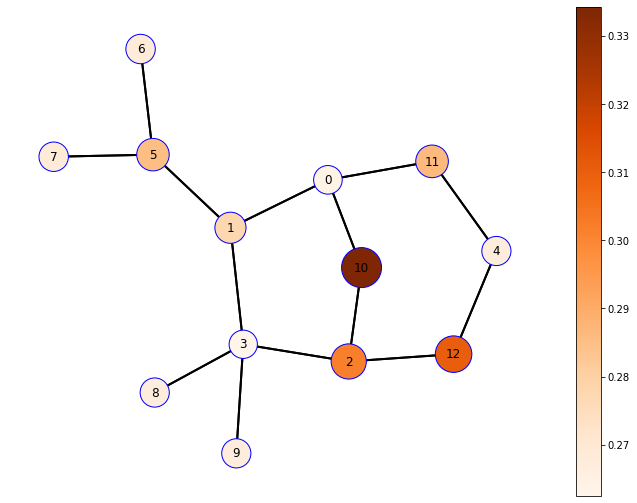

[0.2641281187534332, 0.2777906060218811, 0.30193445086479187, 0.26251021027565, 0.26705461740493774, 0.2854404151439667, 0.26836323738098145, 0.26836323738098145, 0.2670539617538452, 0.2670539617538452, 0.33429187536239624, 0.2863433361053467, 0.31037282943725586]
[10 12  2 11  5  1  7  6  4  9  8  0  3]
truth node:  [0, 2, 4, 10, 11, 12]
acc:  0.6666666666666666
auc:  0.7619047619047619
mean acc:  0.6666666666666666
mean auc:  0.7619047619047619

index:  517
0 label:  1
node range:  [517, 1, 3, 35, 36, 519, 7, 521, 8, 37, 38, 518, 522, 520, 17, 18]
target node:  517
epoch time:  0.12757062911987305


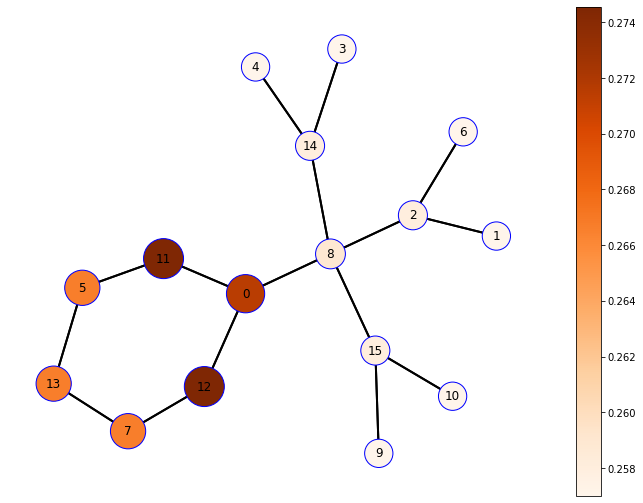

[0.2715386748313904, 0.2570036053657532, 0.2579856812953949, 0.25700345635414124, 0.2570035457611084, 0.26673945784568787, 0.2570036053657532, 0.26673948764801025, 0.25898727774620056, 0.25700345635414124, 0.25700342655181885, 0.27456149458885193, 0.2745615541934967, 0.26667794585227966, 0.2579856812953949, 0.2579856812953949]
[12 11  0  7  5 13  8 15 14  2  6  1  4  9  3 10]
truth node:  [0, 5, 7, 11, 12, 13]
acc:  1.0
auc:  1.0
mean acc:  0.8333333333333333
mean auc:  0.8809523809523809

index:  523
0 label:  1
node range:  [523, 33, 34, 3, 67, 68, 69, 7, 70, 524, 525, 526, 527, 15, 16, 528, 538]
target node:  523
epoch time:  0.12434530258178711


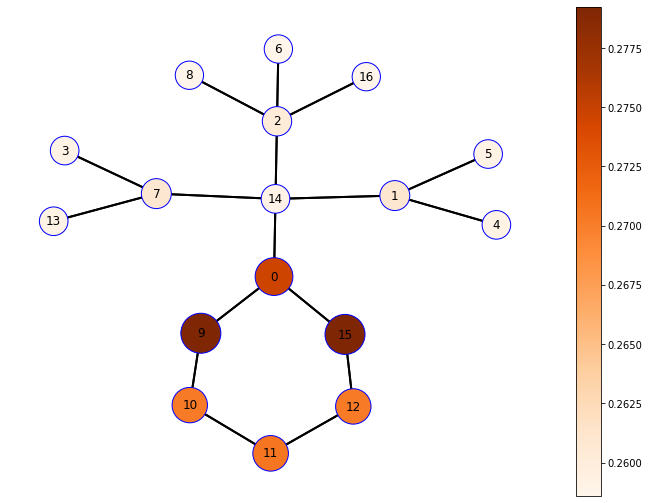

[0.274714857339859, 0.26106828451156616, 0.26021116971969604, 0.2590702772140503, 0.25907018780708313, 0.25907018780708313, 0.2585966885089874, 0.2610682249069214, 0.2585966885089874, 0.2792447507381439, 0.27029040455818176, 0.27063873410224915, 0.27029040455818176, 0.2590702772140503, 0.2591603100299835, 0.27924495935440063, 0.2585966885089874]
[15  9  0 11 12 10  1  7  2 14 13  3  5  4 16  6  8]
truth node:  [0, 9, 10, 11, 12, 15]
acc:  1.0
auc:  1.0
mean acc:  0.8888888888888888
mean auc:  0.9206349206349206

index:  529
0 label:  1
node range:  [529, 99, 100, 5, 101, 102, 11, 49, 531, 50, 533, 530, 23, 24, 534, 26, 532]
target node:  529
epoch time:  0.12632441520690918


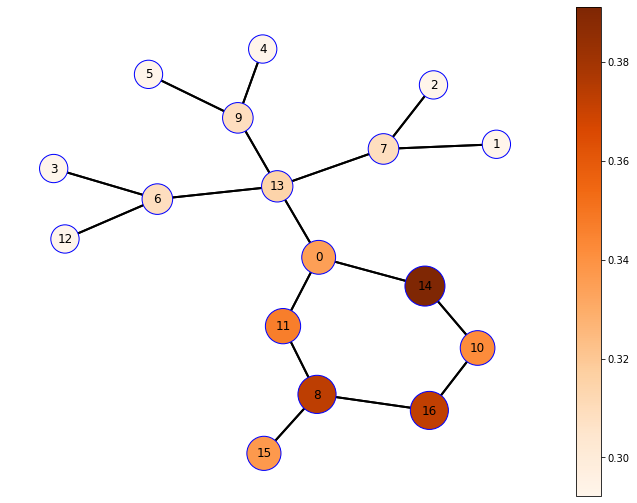

[0.33502069115638733, 0.292254239320755, 0.292254239320755, 0.2922544479370117, 0.292254239320755, 0.292254239320755, 0.3089165687561035, 0.30891644954681396, 0.3733314275741577, 0.30891644954681396, 0.3418467044830322, 0.34702810645103455, 0.2922542691230774, 0.31472599506378174, 0.3911688029766083, 0.33728015422821045, 0.3725205063819885]
[14  8 16 11 10 15  0 13  6  9  7  3 12  5  4  2  1]
truth node:  [0, 8, 10, 11, 14, 16]
acc:  0.8333333333333334
auc:  0.9848484848484849
mean acc:  0.875
mean auc:  0.9366883116883117

index:  535
0 label:  1
node range:  [535, 32, 65, 66, 131, 132, 133, 134, 7, 96, 15, 536, 537, 538, 539, 540, 31]
target node:  535
epoch time:  0.13969755172729492


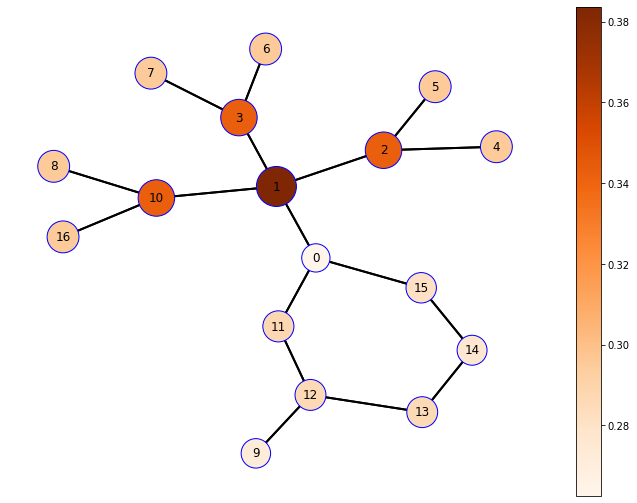

[0.2625834047794342, 0.3837362229824066, 0.34294214844703674, 0.34294214844703674, 0.29524117708206177, 0.2952410876750946, 0.29524117708206177, 0.2952410876750946, 0.295241117477417, 0.2727600336074829, 0.34294214844703674, 0.287796288728714, 0.2862872779369354, 0.28580838441848755, 0.27719080448150635, 0.2814962565898895, 0.29524120688438416]
[ 1  2  3 10 16  6  4  8  7  5 11 12 13 15 14  9  0]
truth node:  [0, 11, 12, 13, 14, 15]
acc:  0.0
auc:  0.07575757575757579
mean acc:  0.7
mean auc:  0.7645021645021645

index:  541
0 label:  1
node range:  [541, 544, 545, 546, 163, 164, 573, 165, 39, 40, 9, 166, 81, 82, 19, 542, 543]
target node:  541
epoch time:  0.13956141471862793


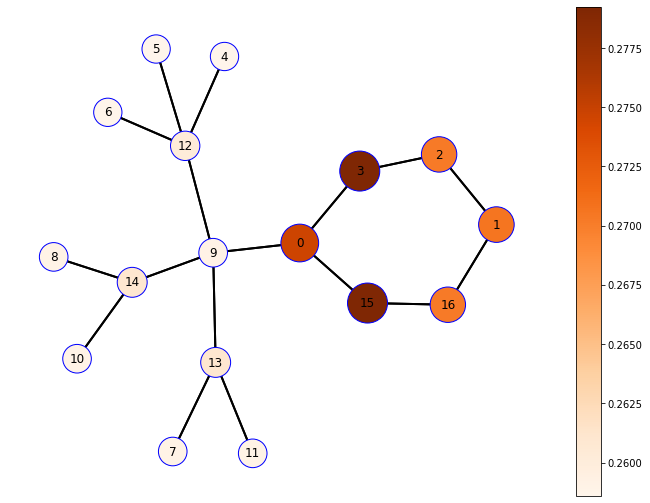

[0.274714857339859, 0.27063873410224915, 0.2702902853488922, 0.27924469113349915, 0.25859665870666504, 0.2585966885089874, 0.25859665870666504, 0.25907018780708313, 0.2590702772140503, 0.2591603100299835, 0.25907018780708313, 0.25907018780708313, 0.26021116971969604, 0.26106831431388855, 0.26106831431388855, 0.27924495935440063, 0.2702905237674713]
[15  3  0  1 16  2 13 14 12  9  8 11 10  7  5  6  4]
truth node:  [0, 1, 2, 3, 15, 16]
acc:  1.0
auc:  1.0
mean acc:  0.75
mean auc:  0.8037518037518038

index:  547
0 label:  1
node range:  [547, 97, 98, 195, 549, 196, 551, 197, 198, 548, 11, 552, 550, 47, 48, 23]
target node:  547
epoch time:  0.12697052955627441


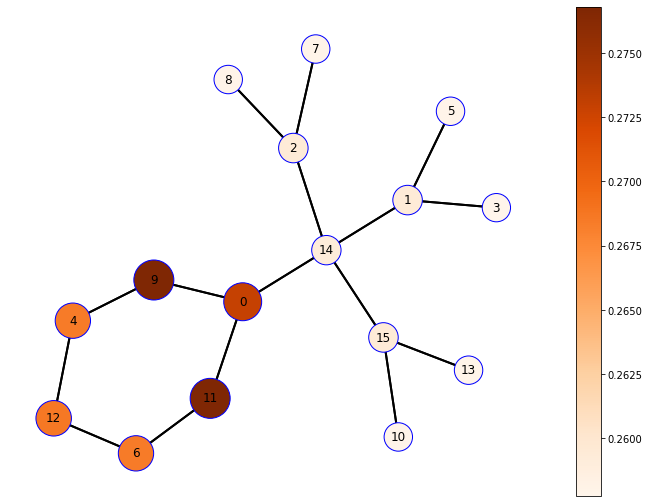

[0.27295196056365967, 0.25946447253227234, 0.2594594955444336, 0.25776493549346924, 0.26842430233955383, 0.2579536736011505, 0.26842427253723145, 0.25794848799705505, 0.25794848799705505, 0.27680620551109314, 0.25794848799705505, 0.2768063545227051, 0.2686918079853058, 0.25794851779937744, 0.25924208760261536, 0.25945955514907837]
[11  9  0 12  4  6  1 15  2 14  5 13 10  8  7  3]
truth node:  [0, 4, 6, 9, 11, 12]
acc:  1.0
auc:  1.0
mean acc:  0.7857142857142857
mean auc:  0.8317872603586889

index:  553
0 label:  1
node range:  [553, 227, 228, 229, 230, 554, 555, 59, 557, 13, 558, 556, 113, 114, 598, 55, 56, 27]
target node:  553
epoch time:  0.1571192741394043


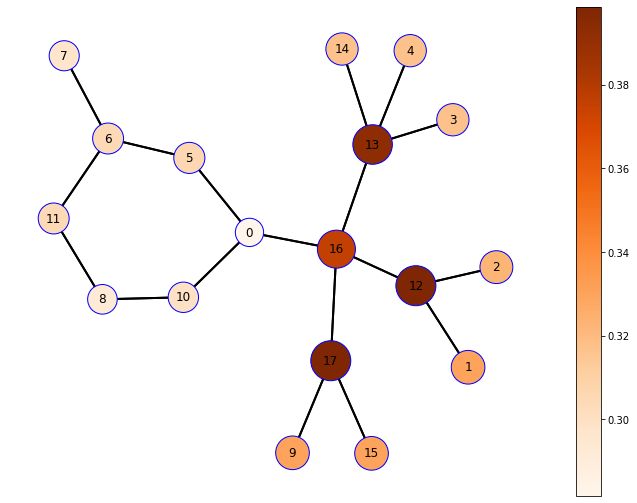

[0.2817307710647583, 0.3302341401576996, 0.32281363010406494, 0.3171336054801941, 0.3171336054801941, 0.30620908737182617, 0.3046318292617798, 0.2970948815345764, 0.2928321361541748, 0.3305177092552185, 0.2996803820133209, 0.3047058880329132, 0.3986804783344269, 0.39285412430763245, 0.3171336054801941, 0.3305181562900543, 0.3761385679244995, 0.3985043168067932]
[12 17 13 16 15  9  1  2 14  4  3  5 11  6 10  7  8  0]
truth node:  [0, 5, 6, 8, 10, 11]
acc:  0.0
auc:  0.05555555555555558
mean acc:  0.6875
mean auc:  0.7347582972582973

index:  559
0 label:  1
node range:  [559, 64, 129, 130, 259, 260, 261, 262, 15, 561, 560, 563, 564, 562, 63, 31]
target node:  559
epoch time:  0.15316438674926758


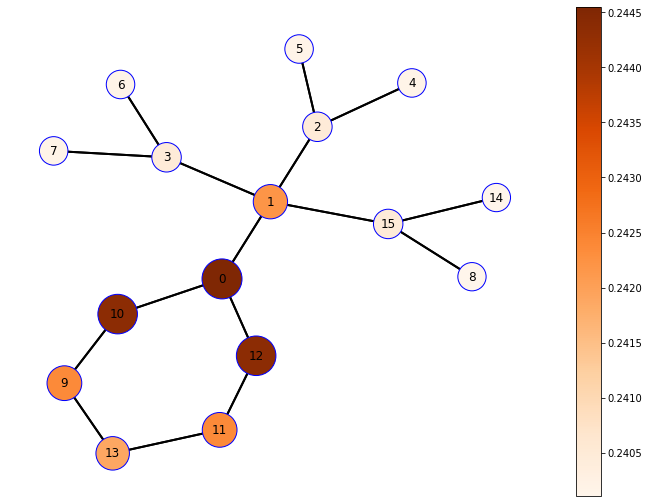

[0.24455218017101288, 0.24220040440559387, 0.24048970639705658, 0.24048975110054016, 0.24017515778541565, 0.24017515778541565, 0.2401750683784485, 0.24017515778541565, 0.2401086390018463, 0.24237239360809326, 0.2443532794713974, 0.24237242341041565, 0.2443532943725586, 0.24189487099647522, 0.2401086390018463, 0.24047885835170746]
[ 0 12 10 11  9  1 13  3  2 15  7  5  4  6 14  8]
truth node:  [0, 9, 10, 11, 12, 13]
acc:  0.8333333333333334
auc:  0.9833333333333334
mean acc:  0.7037037037037037
mean auc:  0.7623777457110791

index:  565
0 label:  1
node range:  [565, 35, 291, 292, 293, 71, 72, 294, 145, 146, 17, 566, 567, 568, 569, 570]
target node:  565
epoch time:  0.12554073333740234


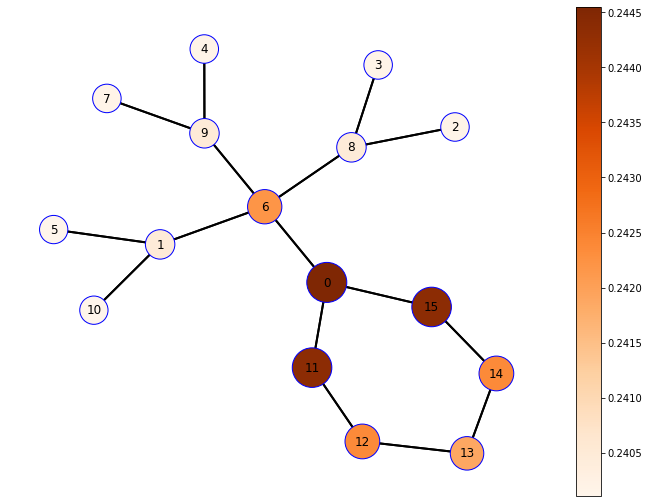

[0.24455220997333527, 0.24047888815402985, 0.24017515778541565, 0.24017515778541565, 0.24017515778541565, 0.24010872840881348, 0.24220040440559387, 0.24017515778541565, 0.24048975110054016, 0.24048975110054016, 0.24010872840881348, 0.2443532794713974, 0.24237249791622162, 0.24189487099647522, 0.2423725128173828, 0.2443532794713974]
[ 0 15 11 14 12  6 13  9  8  1  7  4  3  2 10  5]
truth node:  [0, 11, 12, 13, 14, 15]
acc:  0.8333333333333334
auc:  0.9833333333333333
mean acc:  0.7166666666666666
mean auc:  0.7844733044733045

index:  577
0 label:  1
node range:  [577, 578, 579, 355, 581, 356, 646, 357, 358, 582, 43, 580, 177, 178, 21, 87, 88, 90]
target node:  577
epoch time:  0.1468946933746338


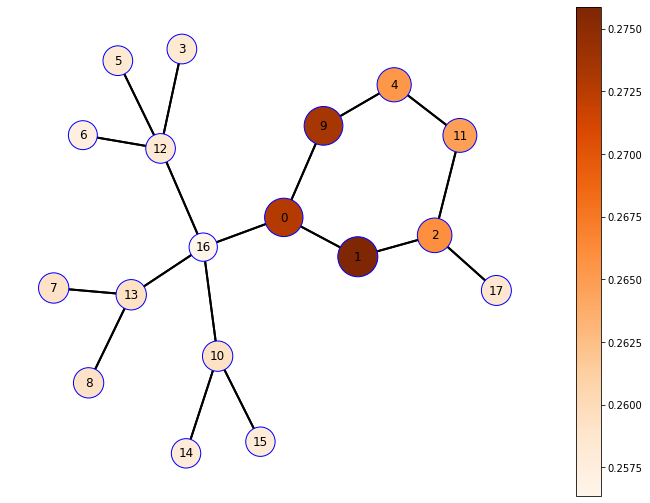

[0.2727726697921753, 0.2758813500404358, 0.2660042941570282, 0.2583470046520233, 0.26531845331192017, 0.25834694504737854, 0.25727570056915283, 0.2592387795448303, 0.25923874974250793, 0.2734138071537018, 0.2592948079109192, 0.2648108899593353, 0.25826871395111084, 0.25931516289711, 0.2578977644443512, 0.2578977644443512, 0.25635769963264465, 0.2587217390537262]
[ 1  9  0  2  4 11 13 10  7  8 17  3  5 12 14 15  6 16]
truth node:  [0, 1, 2, 4, 9, 11]
acc:  1.0
auc:  1.0
mean acc:  0.7424242424242423
mean auc:  0.8040666404302769

index:  583
0 label:  1
node range:  [583, 387, 388, 389, 390, 23, 536, 537, 538, 47, 193, 194, 584, 585, 586, 587, 588, 95, 96]
target node:  583
epoch time:  0.15300393104553223


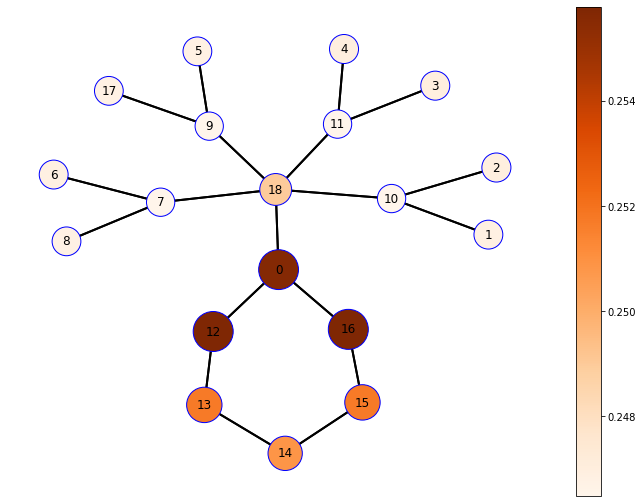

[0.25563156604766846, 0.2468559741973877, 0.24698683619499207, 0.24697238206863403, 0.24697242677211761, 0.24680522084236145, 0.24687805771827698, 0.24648155272006989, 0.24679704010486603, 0.24647948145866394, 0.24648641049861908, 0.246489018201828, 0.2557956278324127, 0.25175467133522034, 0.25086650252342224, 0.25175467133522034, 0.25579550862312317, 0.24680522084236145, 0.24897506833076477]
[12 16  0 15 13 14 18  2  4  3  6  1 17  5  8 11 10  7  9]
truth node:  [0, 6, 7, 8, 12, 13, 14, 15, 16]
acc:  1.0
auc:  0.7777777777777778
mean acc:  0.7638888888888888
mean auc:  0.801875901875902

index:  589
0 label:  1
node range:  [589, 25, 419, 420, 421, 422, 51, 52, 590, 591, 592, 593, 209, 210, 594, 211, 212, 103, 104, 105]
target node:  589
epoch time:  0.16180753707885742


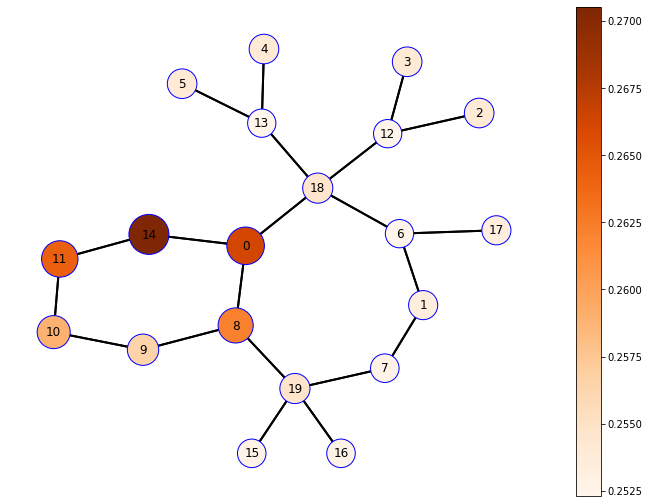

[0.26625749468803406, 0.2533832788467407, 0.2540742754936218, 0.25407424569129944, 0.2540742754936218, 0.2540742754936218, 0.2523351013660431, 0.25264814496040344, 0.2621860206127167, 0.2564527690410614, 0.2589484751224518, 0.2643330693244934, 0.2523135542869568, 0.2523135542869568, 0.27052921056747437, 0.25264814496040344, 0.25264814496040344, 0.2533832788467407, 0.2547692060470581, 0.2548068165779114]
[14  0 11  8 10  9 19 18  5  4  2  3 17  1 15 16  7  6 13 12]
truth node:  [0, 8, 9, 10, 11, 14]
acc:  1.0
auc:  1.0
mean acc:  0.782051282051282
mean auc:  0.8171162171162172

index:  595
0 label:  1
node range:  [595, 225, 226, 451, 452, 453, 599, 454, 111, 112, 596, 597, 598, 55, 600, 27, 92]
target node:  595
epoch time:  0.15798616409301758


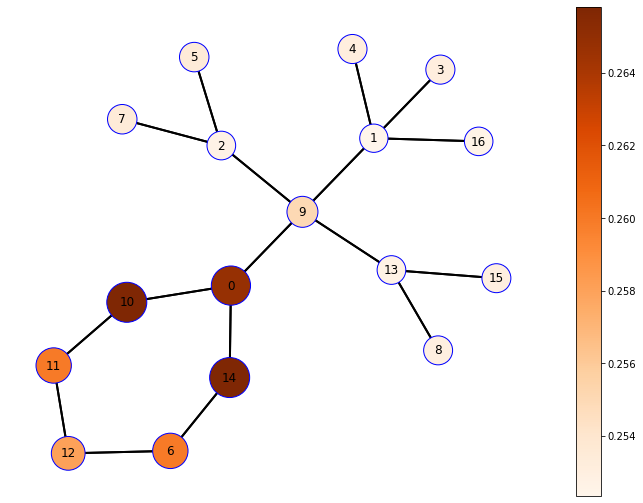

[0.2647745907306671, 0.2523423433303833, 0.2526955008506775, 0.25312337279319763, 0.25312337279319763, 0.2534998953342438, 0.25994759798049927, 0.2534998953342438, 0.2529849708080292, 0.25503984093666077, 0.2658260464668274, 0.2599475383758545, 0.2580703794956207, 0.2527235746383667, 0.26582610607147217, 0.2529849708080292, 0.25257766246795654]
[14 10  0  6 11 12  9  5  7  3  4  8 15 13  2 16  1]
truth node:  [0, 6, 10, 11, 12, 14]
acc:  1.0
auc:  1.0
mean acc:  0.7976190476190476
mean auc:  0.8301793444650588

index:  601
0 label:  1
node range:  [601, 29, 555, 694, 59, 602, 603, 604, 605, 606, 480, 483, 484, 485, 486, 241, 242, 119, 120]
target node:  601
epoch time:  0.15706443786621094


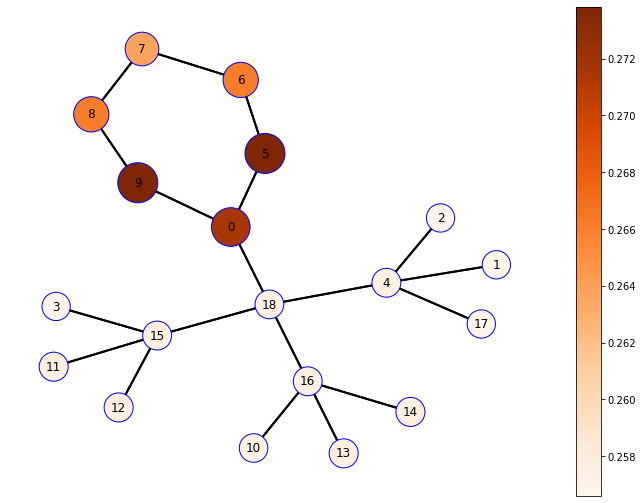

[0.2715487778186798, 0.25660309195518494, 0.25660309195518494, 0.25660791993141174, 0.2573245167732239, 0.27383309602737427, 0.2661658823490143, 0.2637495696544647, 0.2661657929420471, 0.2738330066204071, 0.2569468915462494, 0.25750911235809326, 0.25750911235809326, 0.2575101852416992, 0.2575101852416992, 0.25732865929603577, 0.25732937455177307, 0.2566031515598297, 0.25710511207580566]
[ 5  9  0  6  8  7 14 13 12 11 16 15  4 18 10  3 17  2  1]
truth node:  [0, 5, 6, 7, 8, 9]
acc:  1.0
auc:  1.0
mean acc:  0.8111111111111111
mean auc:  0.8415007215007216

index:  619
0 label:  1
node range:  [619, 289, 290, 35, 71, 295, 73, 296, 620, 621, 622, 623, 143, 144, 624, 147, 728]
target node:  619
epoch time:  0.15422511100769043


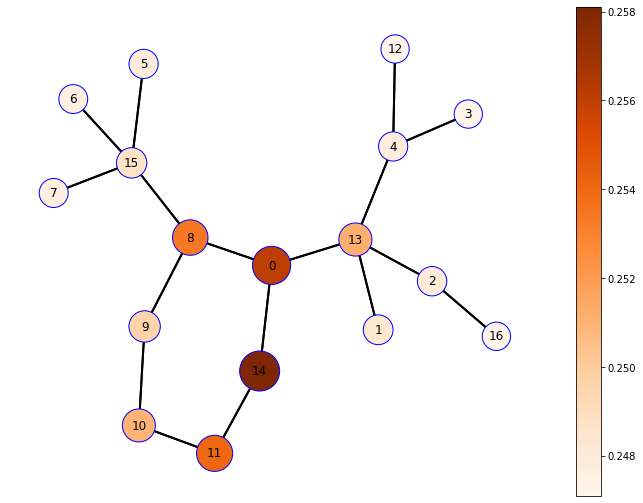

[0.25612539052963257, 0.2482738345861435, 0.24797482788562775, 0.24709664285182953, 0.24781687557697296, 0.24781256914138794, 0.24756549298763275, 0.24765771627426147, 0.2534061074256897, 0.2496533840894699, 0.25105297565460205, 0.2540455758571625, 0.24709664285182953, 0.2511832118034363, 0.2581142485141754, 0.24876050651073456, 0.2471196949481964]
[14  0 11  8 13 10  9 15  1  2  4  5  7  6 16 12  3]
truth node:  [0, 8, 9, 10, 11, 14]
acc:  0.8333333333333334
auc:  0.9696969696969696
mean acc:  0.8125
mean auc:  0.8495129870129869

index:  625
0 label:  1
node range:  [625, 576, 37, 742, 75, 80, 305, 627, 306, 629, 626, 151, 152, 630, 628, 571, 572]
target node:  625
epoch time:  0.14873170852661133


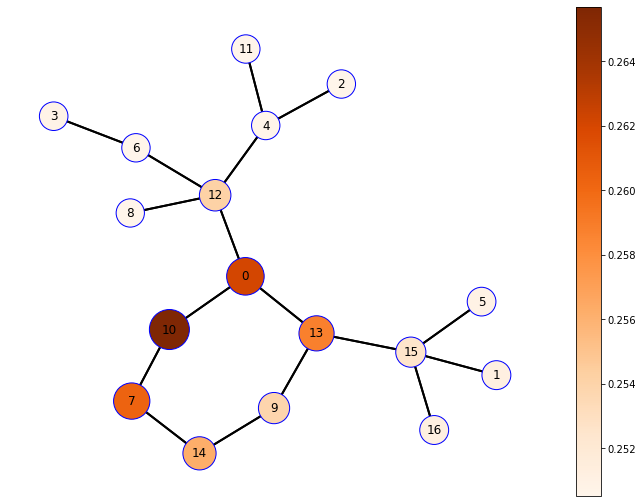

[0.26210635900497437, 0.2511874735355377, 0.25062188506126404, 0.25080928206443787, 0.25063440203666687, 0.250967413187027, 0.25061869621276855, 0.2603617310523987, 0.25051867961883545, 0.2538403570652008, 0.26570141315460205, 0.25062188506126404, 0.2541756331920624, 0.2588077783584595, 0.2562459111213684, 0.2525883615016937, 0.2511874735355377]
[10  0  7 13 14 12  9 15  1 16  5  3  4  2 11  6  8]
truth node:  [0, 1, 7, 9, 10, 13, 14, 15, 16]
acc:  0.8333333333333334
auc:  0.9444444444444444
mean acc:  0.8137254901960784
mean auc:  0.8550971903913079

index:  631
0 label:  1
node range:  [631, 160, 161, 321, 322, 323, 324, 39, 79, 80, 754, 632, 633, 634, 635, 636, 159]
target node:  631
epoch time:  0.14043068885803223


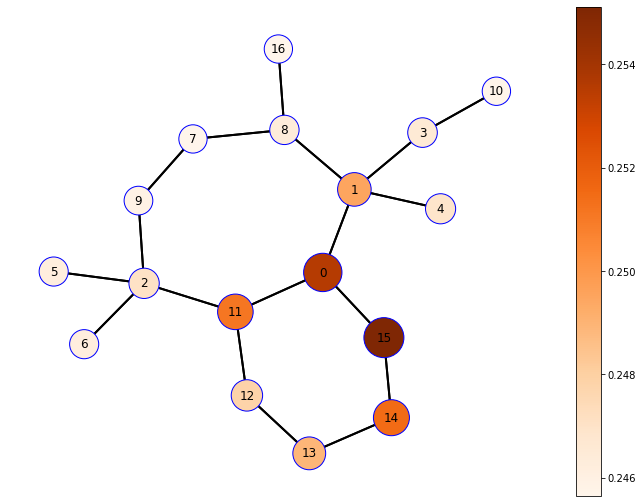

[0.2535819113254547, 0.2495277374982834, 0.24705536663532257, 0.24655072391033173, 0.24692082405090332, 0.24620220065116882, 0.24620220065116882, 0.24564875662326813, 0.24636328220367432, 0.24593204259872437, 0.24569083750247955, 0.2511468231678009, 0.2478346824645996, 0.24893486499786377, 0.2515181303024292, 0.25511500239372253, 0.24564877152442932]
[15  0 14 11  1 13 12  2  4  3  8  5  6  9 10 16  7]
truth node:  [0, 11, 12, 13, 14, 15]
acc:  0.8333333333333334
auc:  0.9696969696969697
mean acc:  0.8148148148148149
mean auc:  0.8614638447971781

index:  637
0 label:  1
node range:  [637, 640, 641, 642, 167, 168, 41, 765, 337, 338, 83, 638, 639]
target node:  637
epoch time:  0.11129164695739746


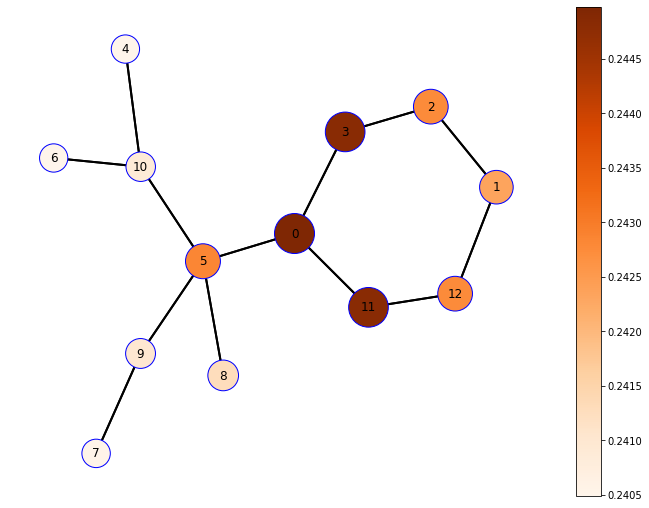

[0.2449783980846405, 0.24233779311180115, 0.24276651442050934, 0.24482253193855286, 0.24049043655395508, 0.2428450733423233, 0.24049043655395508, 0.2405327558517456, 0.2412840873003006, 0.24100887775421143, 0.24087613821029663, 0.2448224574327469, 0.24276652932167053]
[ 0  3 11  5 12  2  1  8  9 10  7  6  4]
truth node:  [0, 1, 2, 3, 11, 12]
acc:  0.8333333333333334
auc:  0.9285714285714285
mean acc:  0.8157894736842106
mean auc:  0.8649958228905597

index:  649
0 label:  1
node range:  [649, 650, 651, 652, 653, 45, 654, 187, 369, 370, 183, 184, 121, 91]
target node:  649
epoch time:  0.11156225204467773


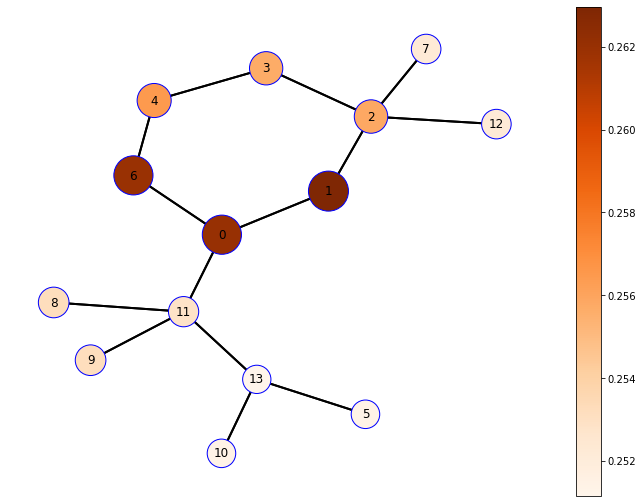

[0.26200640201568604, 0.2629728615283966, 0.25585633516311646, 0.2557116448879242, 0.25649791955947876, 0.2513497769832611, 0.2619681656360626, 0.252247154712677, 0.25320595502853394, 0.2532059848308563, 0.2513498067855835, 0.25283581018447876, 0.2522471845149994, 0.25115156173706055]
[ 1  0  6  4  2  3  9  8 11 12  7 10  5 13]
truth node:  [0, 1, 2, 3, 4, 6]
acc:  1.0
auc:  1.0
mean acc:  0.825
mean auc:  0.8717460317460317

index:  655
0 label:  1
node range:  [655, 192, 385, 386, 191, 195, 47, 657, 656, 659, 660, 658, 95]
target node:  655
epoch time:  0.10721087455749512


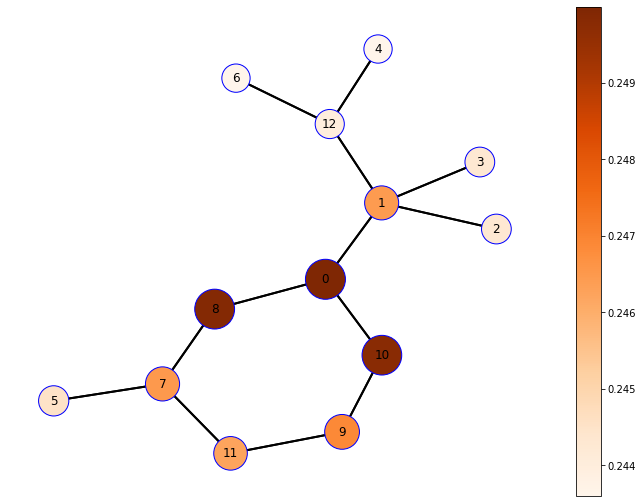

[0.24999377131462097, 0.24646733701229095, 0.2442823052406311, 0.2442823052406311, 0.24360132217407227, 0.24451075494289398, 0.24360132217407227, 0.24651683866977692, 0.24989163875579834, 0.24688021838665009, 0.24978940188884735, 0.24623039364814758, 0.24399502575397491]
[ 0  8 10  9  7  1 11  5  3  2 12  6  4]
truth node:  [0, 7, 8, 9, 10, 11]
acc:  0.8333333333333334
auc:  0.9761904761904763
mean acc:  0.8253968253968254
mean auc:  0.8767195767195768

index:  673
0 label:  1
node range:  [673, 674, 675, 676, 677, 837, 678, 107, 433, 434, 53, 215, 216]
target node:  673
epoch time:  0.12199997901916504


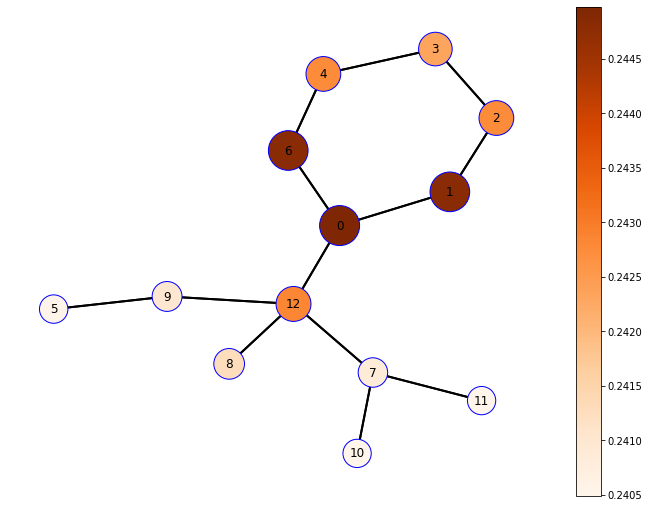

[0.2449783980846405, 0.24482253193855286, 0.24276651442050934, 0.24233779311180115, 0.24276645481586456, 0.2405327558517456, 0.2448224574327469, 0.24087609350681305, 0.2412840873003006, 0.24100883305072784, 0.24049042165279388, 0.24049042165279388, 0.2428450733423233]
[ 0  1  6 12  2  4  3  8  9  7  5 11 10]
truth node:  [0, 1, 2, 3, 4, 6]
acc:  0.8333333333333334
auc:  0.9285714285714285
mean acc:  0.8257575757575757
mean auc:  0.879076479076479

index:  679
0 label:  1
node range:  [679, 224, 449, 450, 680, 681, 682, 683, 684, 111, 848, 55, 223]
target node:  679
epoch time:  0.10305428504943848


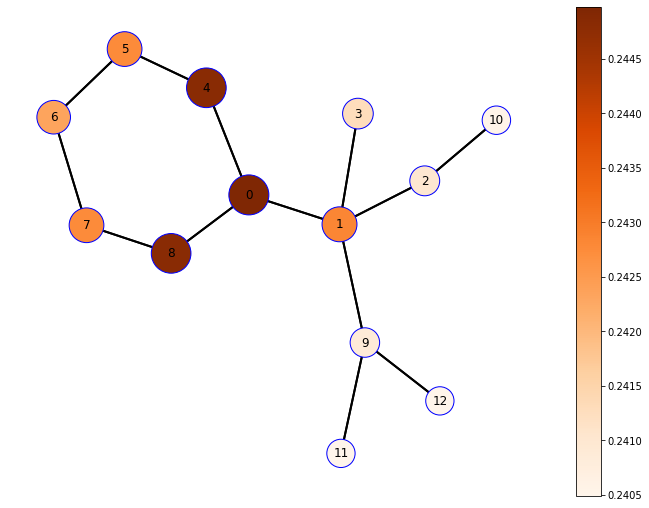

[0.2449783980846405, 0.2428450733423233, 0.24100883305072784, 0.2412840873003006, 0.24482251703739166, 0.2427665889263153, 0.24233779311180115, 0.2427665889263153, 0.24482251703739166, 0.24087607860565186, 0.2405327707529068, 0.24049042165279388, 0.24049042165279388]
[ 0  8  4  1  7  5  6  3  2  9 10 12 11]
truth node:  [0, 4, 5, 6, 7, 8]
acc:  0.8333333333333334
auc:  0.9285714285714285
mean acc:  0.826086956521739
mean auc:  0.8812284334023464

index:  685
0 label:  1
node range:  [685, 228, 231, 232, 457, 458, 235, 686, 687, 688, 689, 465, 115, 466, 113, 690, 57, 860]
target node:  685
epoch time:  0.1565873622894287


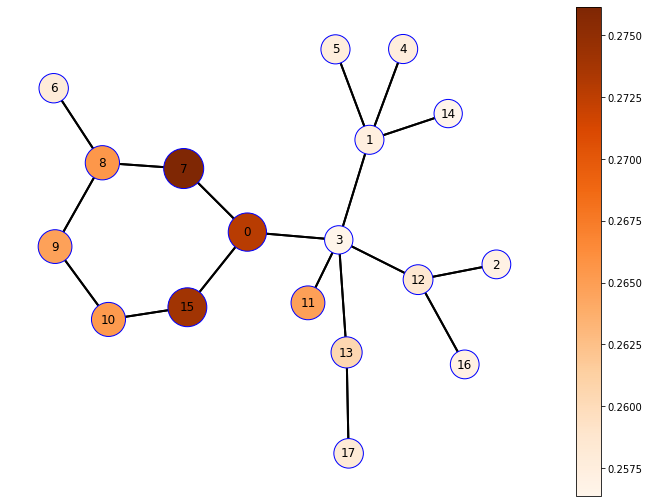

[0.2728000581264496, 0.2574363350868225, 0.25703057646751404, 0.2564525604248047, 0.25754135847091675, 0.25754135847091675, 0.25792452692985535, 0.2761654853820801, 0.26557156443595886, 0.26478493213653564, 0.2652721703052521, 0.2648772895336151, 0.2585301995277405, 0.26051759719848633, 0.25637388229370117, 0.2739737629890442, 0.25703057646751404, 0.2581438422203064]
[ 7 15  0  8 10 11  9 13 12 17  6  5  4  1 16  2  3 14]
truth node:  [0, 7, 8, 9, 10, 15]
acc:  0.8333333333333334
auc:  0.986111111111111
mean acc:  0.826388888888889
mean auc:  0.885598544973545

index:  691
0 label:  1
node range:  [691, 481, 482, 695, 239, 240, 692, 693, 694, 119, 696, 59]
target node:  691
epoch time:  0.09285497665405273


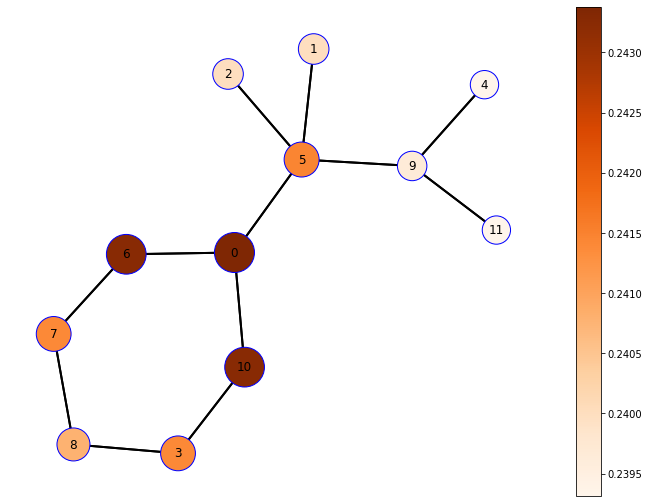

[0.24338088929653168, 0.24000173807144165, 0.2400016188621521, 0.24140770733356476, 0.23932909965515137, 0.24146828055381775, 0.2432640939950943, 0.24140779674053192, 0.24078258872032166, 0.2396603375673294, 0.2432640939950943, 0.23931579291820526]
[ 0 10  6  5  7  3  8  1  2  9  4 11]
truth node:  [0, 3, 6, 7, 8, 10]
acc:  0.8333333333333334
auc:  0.9166666666666667
mean acc:  0.8266666666666667
mean auc:  0.8868412698412699

index:  709
0 label:  1
node range:  [709, 65, 131, 710, 711, 263, 713, 264, 714, 712, 573, 574, 575]
target node:  709
epoch time:  0.1124734878540039


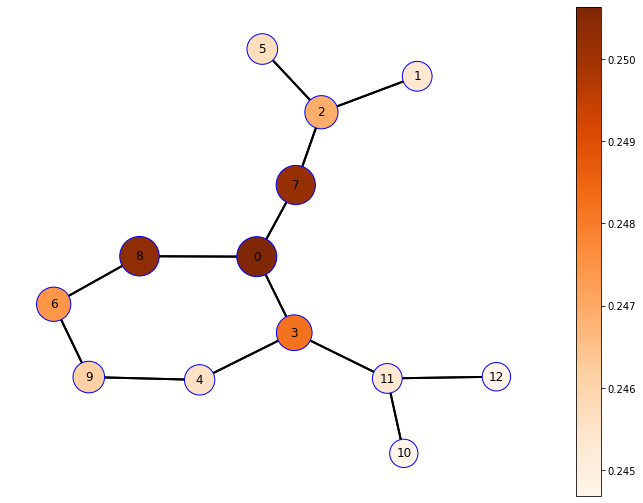

[0.2506386637687683, 0.24532319605350494, 0.24693039059638977, 0.24821032583713531, 0.24558696150779724, 0.24571816623210907, 0.24747279286384583, 0.25017884373664856, 0.2503250241279602, 0.2461603581905365, 0.2446879744529724, 0.24533219635486603, 0.2447371631860733]
[ 0  8  7  3  6  2  9  5  4 11  1 12 10]
truth node:  [0, 3, 4, 6, 8, 9, 10, 11, 12]
acc:  0.6666666666666666
auc:  0.5
mean acc:  0.8205128205128206
mean auc:  0.8719627594627595

index:  727
0 label:  1
node range:  [727, 288, 290, 71, 143, 144, 728, 729, 730, 731, 732, 287]
target node:  727
epoch time:  0.09961962699890137


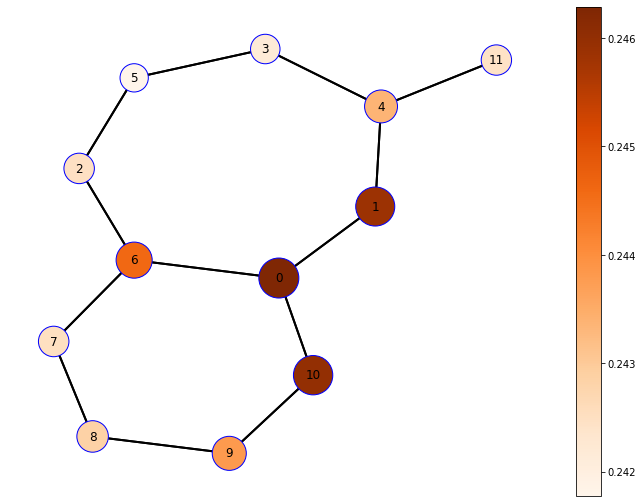

[0.24629056453704834, 0.24586078524589539, 0.242498517036438, 0.24217018485069275, 0.24338054656982422, 0.24177800118923187, 0.2446112185716629, 0.2425125390291214, 0.24286514520645142, 0.243806853890419, 0.24599115550518036, 0.2424614280462265]
[ 0 10  1  6  9  4  8  7  2 11  3  5]
truth node:  [0, 6, 7, 8, 9, 10]
acc:  0.6666666666666666
auc:  0.8333333333333334
mean acc:  0.814814814814815
mean auc:  0.8705320399764844

index:  745
0 label:  1
node range:  [745, 312, 746, 747, 748, 749, 77, 750, 791, 787, 311, 792, 155]
target node:  745
epoch time:  0.11521315574645996


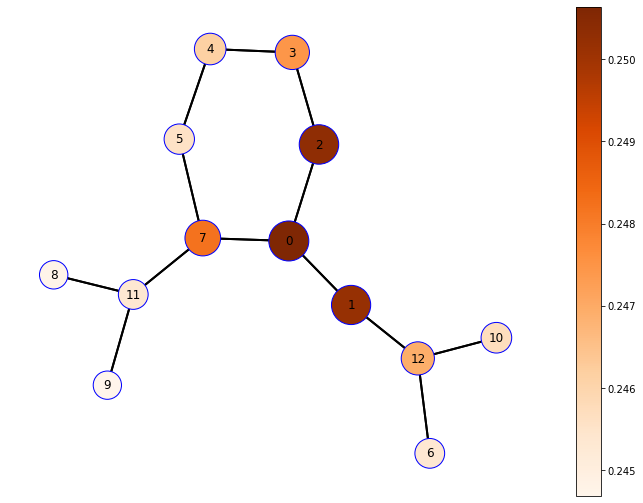

[0.2506386935710907, 0.25017887353897095, 0.2503250241279602, 0.24747279286384583, 0.2461603879928589, 0.24558696150779724, 0.2453230917453766, 0.24821023643016815, 0.24473707377910614, 0.2446879744529724, 0.2457180768251419, 0.2453322410583496, 0.24693039059638977]
[ 0  2  1  7  3 12  4 10  5 11  6  8  9]
truth node:  [0, 2, 3, 4, 5, 7, 8, 9, 11]
acc:  0.6666666666666666
auc:  0.5
mean acc:  0.8095238095238096
mean auc:  0.8572987528344671

index:  775
0 label:  1
node range:  [775, 352, 776, 777, 778, 779, 780, 46, 175, 87, 190, 189, 94, 351]
target node:  775
epoch time:  0.10780811309814453


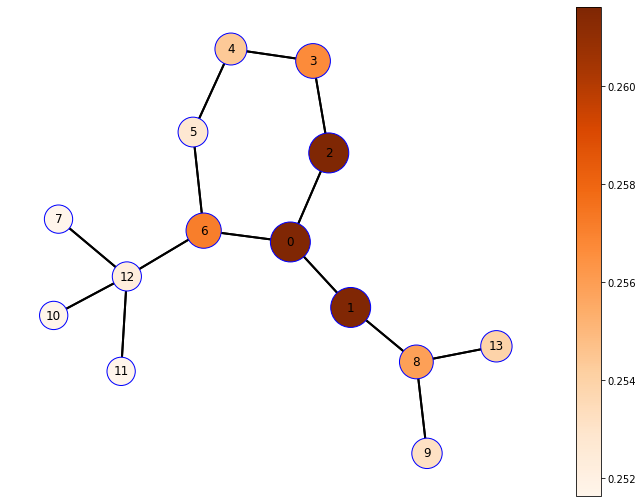

[0.2615702152252197, 0.26155462861061096, 0.26162365078926086, 0.25670114159584045, 0.2543894946575165, 0.2527507543563843, 0.2571496367454529, 0.25163668394088745, 0.25591614842414856, 0.25316718220710754, 0.25163668394088745, 0.25163668394088745, 0.25225329399108887, 0.2539431154727936]
[ 2  0  1  6  3  8  4 13  9  5 12 11 10  7]
truth node:  [0, 2, 3, 4, 5, 6]
acc:  0.6666666666666666
auc:  0.8333333333333334
mean acc:  0.8045977011494255
mean auc:  0.8564723590585659

index:  787
0 label:  1
node range:  [787, 185, 745, 749, 750, 367, 368, 371, 789, 788, 791, 792, 183, 790, 91]
target node:  787
epoch time:  0.13361048698425293


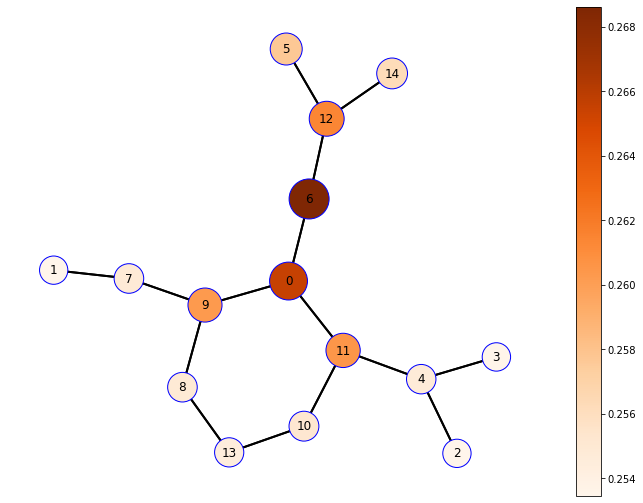

[0.2654880881309509, 0.25345706939697266, 0.25347191095352173, 0.2535644769668579, 0.25472187995910645, 0.2576931118965149, 0.26861903071403503, 0.2548763155937195, 0.25489988923072815, 0.2602878212928772, 0.25519803166389465, 0.2605621814727783, 0.2614033818244934, 0.25445201992988586, 0.25627952814102173]
[ 6  0 12 11  9  5 14 10  8  7  4 13  3  2  1]
truth node:  [0, 2, 3, 4, 8, 9, 10, 11, 13]
acc:  0.5
auc:  0.3888888888888889
mean acc:  0.7944444444444446
mean auc:  0.8408862433862434

index:  847
0 label:  1
node range:  [847, 448, 449, 224, 447, 111, 849, 848, 851, 852, 850, 223]
target node:  847
epoch time:  0.09172964096069336


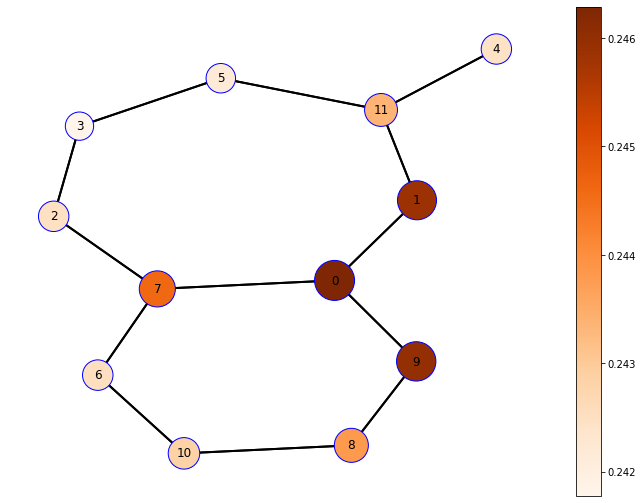

[0.24629054963588715, 0.24586087465286255, 0.24249842762947083, 0.24177812039852142, 0.2424614578485489, 0.24217022955417633, 0.24251265823841095, 0.2446112036705017, 0.2438068836927414, 0.2459910660982132, 0.24286507070064545, 0.2433806210756302]
[ 0  9  1  7  8 11 10  6  2  4  5  3]
truth node:  [0, 6, 7, 8, 9, 10]
acc:  0.6666666666666666
auc:  0.8333333333333334
mean acc:  0.7903225806451615
mean auc:  0.840642601126472

index:  859
0 label:  1
node range:  [859, 864, 231, 232, 463, 464, 466, 115, 860, 861, 862, 863]
target node:  859
epoch time:  0.11055874824523926


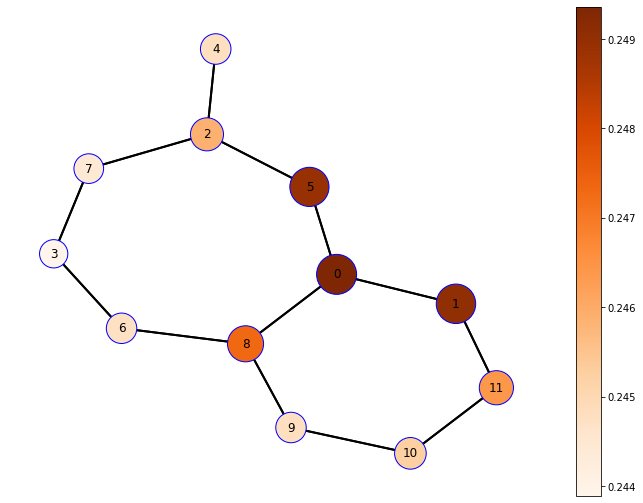

[0.24936136603355408, 0.24906067550182343, 0.2458970546722412, 0.2438916116952896, 0.2447982132434845, 0.2489176094532013, 0.2447553128004074, 0.24443472921848297, 0.24732527136802673, 0.2447785884141922, 0.24526943266391754, 0.24640199542045593]
[ 0  1  5  8 11  2 10  4  9  6  7  3]
truth node:  [0, 1, 8, 9, 10, 11]
acc:  0.6666666666666666
auc:  0.8055555555555556
mean acc:  0.7864583333333334
mean auc:  0.839546130952381


In [39]:
acc_list = []
auc_list = []

dataset.subgraph = False
dataset.remap = False
dataset.setting=1
load_model = gcn_model
#load_model = torch.load('./checkpoint/community_temp')
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
load_model.eval()

all_node_label = []
all_node_color = []
for idx in dataset.allnodes:
    #idx = 519
    if indices[idx] == 0:
        continue
    print('\nindex: ', idx)
    sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.get_subgraph(idx)
    #truth_node = np.where(sub_label[:,1] == True)[0]
    truth_node = list(get_node_set(sub_edge_label_matrix))
    
    class_idx = np.argmax(sub_label[0],axis=-1)
    print('0 label: ', class_idx)
    node_range = dataset.extractor.nodes
    print('node range: ', node_range)
    node_sort, node_color = print_subgraph_explain(dataset = dataset, model = load_model, idx = 0, class_idx = class_idx, visible = True, figsize = (12,9), node_range = node_range)
    print(node_color)
    print(node_sort)

    node_label = np.array([0] * sub_label.shape[0])
    node_label[list(truth_node)] = 1
    # find truth node, far node is not real truth
    #for n in truth_node:
    #    if abs((node_range[n] - node_range[0])) <= 8:
    #        node_label[n] = 1
    #        print(n)

    try:
        auc = roc_auc_score(node_label, node_color)
    except:
        print('foo')
        continue
        auc = 1.0

    print("truth node: ", truth_node)
    #print(node_sort)
    acc = len([node for node in node_sort[:6] if node in truth_node])/6
    acc_list.append(acc)
    auc_list.append(auc)
    #all_node_label.extend(node_label)
    #all_node_color.extend(node_color)
    print('acc: ', acc)
    print('auc: ', auc)
    #if acc == 0.0:
    #    print(node_sort)
    #    print_explain(dataset, load_model, idx, class_idx = np.argmax(sub_label[0],axis=-1), visible = True)
    print('mean acc: ', np.mean(acc_list))
    print('mean auc: ', np.mean(auc_list))
    #break